In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import pickle
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix

import torch.nn.functional as F

import matplotlib.pyplot as plt

In [60]:
device = torch.device("cpu")

In [61]:

with open('data\datav2_resetspline.pkl', 'rb') as f:
    reset_splines = pickle.load(f)
with open('data\datav2_setspline.pkl', 'rb') as f:
    set_splines = pickle.load(f)

In [62]:
# Hyperparameters
input_size = 28*28 
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.01

In [63]:
# Load MNIST dataset with downsampling
transform = transforms.Compose([
    transforms.Resize((20, 20)),  
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data/MNIST', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [64]:
class HardwareAwareOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, set_splines=None, reset_splines = None):
        defaults = dict(lr=lr)
        self.set_splines = set_splines
        self.reset_splines = reset_splines
        super(HardwareAwareOptimizer, self).__init__(params, defaults)

    def step(self):
        def map_weights_to_conductance(weight, min_weight, max_weight, min_conductance, max_conductance):
            # Linear interpolation from weight to conductance
            normalized_weights = (weight - min_weight) / (max_weight - min_weight)
            mapped_conductance = min_conductance + normalized_weights * (max_conductance - min_conductance)
            mapped_conductance = torch.clamp(mapped_conductance, min_conductance, max_conductance)
            return mapped_conductance
        
        def new_conductance(G0, grad):
            
            # G_pos = G0*1.05
            # G_neg = G0*(0.95)
            # Apply the splines based on gradient
            tau = 0.05
            # Masks for set, reset, and no change conditions
            set_mask = torch.ge(grad, tau)       # Apply set spline if grad >= tau
            reset_mask = torch.le(grad, -tau)    # Apply reset spline if grad <= -tau

            # Apply the set and reset splines
            # G_pos = G0 * self.reset_splines['1 us'].ev(G0, -1.85)    # Set spline adjustment
            # G_neg = G0 * self.set_splines['1 us'].ev(G0, 1.83) # Reset spline adjustment
            # G_pos = G0 * self.reset_splines(G0)
            # G_neg = G0 * self.set_splines(G0)

            G_neg = G0 +1.0410955555555556e-09
            G_pos = G0 -2.4080184210526313e-09

            # Use torch.where to select G_pos, G_neg, or G0 based on conditions
            G_new = torch.where(set_mask, G_pos, torch.where(reset_mask, G_neg, G0))

            return G_new
            # positive_mask = torch.le(grad, 0)  # Check for grad >= 0
            # G_pos = G0 * (self.set_splines['1 us'].ev(G0, 2.5))
            # G_neg = G0 * (self.reset_splines['1 us'].ev(G0, -2.5))
            
            # # # Combine both positive and negative cases
            # G_new = torch.where(positive_mask, G_pos, G_neg)
            # return G_new

        def map_conductance_to_weights(conductance, min_conductance, max_conductance, min_weight, max_weight):
            # Reverse mapping from conductance to weight

            normalized_conductance = (conductance - min_conductance) / (max_conductance - min_conductance)
            mapped_weight = min_weight + normalized_conductance * (max_weight - min_weight)
            mapped_weight = torch.clamp(mapped_weight, min_weight, max_weight)
            return mapped_weight

        def map_weights_to_conductance_sine(weight, min_weight, max_weight, min_conductance, max_conductance):
            mid_weight = (max_weight+min_weight)/2
            mid_conductance = (max_conductance + min_conductance)/2
            normalized_weight = (weight - mid_weight)/(max_weight-mid_weight)
            # normalized_conductance = 2/torch.pi * torch.arcsin(normalized_weight)
            # normalized_conductance = torch.sign(normalized_weight) * torch.abs(normalized_weight) ** (1/3)
            # normalized_conductance = normalized_weight ** 5
            normalized_conductance = normalized_weight
            conductance = normalized_conductance * (max_conductance - mid_conductance) + mid_conductance
            return conductance
        
        def map_conductance_to_weights_sine(conductance, min_weight, max_weight, min_conductance, max_conductance):
            mid_weight = (max_weight+min_weight)/2
            mid_conductance = (max_conductance + min_conductance)/2
            normalized_conductance = (conductance - mid_conductance)/(max_conductance - mid_conductance)
            # normalized_weight = torch.sin(normalized_conductance * torch.pi/2)
            # normalized_weight = torch.sign(normalized_conductance) * torch.abs(normalized_conductance) ** (1/5)
            # normalized_weight = normalized_conductance ** 3
            normalized_weight = normalized_conductance
            weight = normalized_weight*(max_weight - mid_weight) + mid_weight
            return weight



        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                min_weight, max_weight = -1.0, 1.0
                min_conductance, max_conductance = 1.0e-8, 1.3e-7
                
                # Get the current weights and gradients
                weight, grad = p.data, p.grad.data

                # 1. Map weights to conductance values
                G0 = map_weights_to_conductance_sine(
                    weight=weight,
                    min_weight=min_weight,
                    max_weight=max_weight,
                    min_conductance=min_conductance,
                    max_conductance=max_conductance
                )

                G0 = torch.clamp(G0, min=min_conductance, max=max_conductance)

                # 2. Modify conductance using spline function based on the gradient
                G_new = new_conductance(G0=G0, grad=grad)

                # 3. Map the new conductance values back to weights
                new_weight = map_conductance_to_weights_sine(
                    conductance=G_new,
                    min_conductance=min_conductance,
                    max_conductance=max_conductance,
                    min_weight=min_weight,
                    max_weight=max_weight
                )
                
                # Update the weights in the optimizer
                p.data.copy_(new_weight)  # In-place update of the weights


In [ ]:
# # Define MLP model with no hidden layers
class SimpleMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for layer in self.children():
            if isinstance(layer, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        x = x.view(-1, input_size)  # Flatten the input
        x = self.fc(x)
        # x = self.softmax(x)
        return x
    


In [66]:

class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.05): 
        super(SimpleCNN, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)  # First convolution layer
        self.bn1 = nn.BatchNorm2d(4)  # Batch normalization
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, stride=1, padding=1)  # Second convolution layer
        self.bn2 = nn.BatchNorm2d(2)  # Batch normalization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling layer
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer with specified probability

        # Fully connected layer
        self.fc1 = nn.Linear(2 * 5 * 5, num_classes)  # Adjust 7x7 based on the input size and pooling

        
        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for layer in self.children():
            if isinstance(layer, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        # Pass through convolutional layers with ReLU activation and pooling
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.pool(x)

        # x = self.pool(F.elu(self.bn1(self.conv1(x))))  # Batch normalization after conv1
        # x = self.pool(F.elu(self.bn2(self.conv2(x))))  # Batch normalization after conv2

        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        # Apply dropout before the fully connected layer
        # x = self.dropout(x)  # Apply dropout

        # Pass through the fully connected layer
        x = self.fc1(x)
        # x = F.softmax(x, dim=1)

        
        
        return x

In [ ]:
# Initialize model, loss, and optimizer
# model = SimpleMLP(input_size, num_classes).to(device)
model = SimpleCNN(num_classes).to(device)
# model_dicts = []
best_loss = 1e9
criterion = nn.CrossEntropyLoss()
optimizer = HardwareAwareOptimizer(model.parameters(), lr=0.01, set_splines=set_splines, reset_splines=reset_splines)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Check total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

# Performance metrics
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
precision_metric = Precision(task="multiclass", num_classes=num_classes, average='macro').to(device)
recall_metric = Recall(task="multiclass", num_classes=num_classes, average='macro').to(device)
f1_score_metric = F1Score(task="multiclass", num_classes=num_classes, average='macro').to(device)

confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)


Total number of parameters: 636


In [ ]:

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Reset metrics
    accuracy_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    f1_score_metric.reset()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

            # Update metrics
            accuracy_metric.update(predicted, targets)
            precision_metric.update(predicted, targets)
            recall_metric.update(predicted, targets)
            f1_score_metric.update(predicted, targets)

    # Compute and print metrics
    accuracy = accuracy_metric.compute().item()
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1_score = f1_score_metric.compute().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/(50000/batch_size):.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")





Epoch [1/20], Loss: 0.6530, Accuracy: 0.8942, Precision: 0.8964, Recall: 0.8940, F1 Score: 0.8937
Epoch [2/20], Loss: 0.4854, Accuracy: 0.9115, Precision: 0.9117, Recall: 0.9109, F1 Score: 0.9107
Epoch [3/20], Loss: 0.4760, Accuracy: 0.8690, Precision: 0.8787, Recall: 0.8673, F1 Score: 0.8658
Epoch [4/20], Loss: 0.4865, Accuracy: 0.9117, Precision: 0.9110, Recall: 0.9109, F1 Score: 0.9106
Epoch [5/20], Loss: 0.4552, Accuracy: 0.9163, Precision: 0.9174, Recall: 0.9157, F1 Score: 0.9156
Epoch [6/20], Loss: 0.4576, Accuracy: 0.9142, Precision: 0.9141, Recall: 0.9133, F1 Score: 0.9132
Epoch [7/20], Loss: 0.4516, Accuracy: 0.8401, Precision: 0.8630, Recall: 0.8411, F1 Score: 0.8407
Epoch [8/20], Loss: 0.4556, Accuracy: 0.9092, Precision: 0.9103, Recall: 0.9087, F1 Score: 0.9071
Epoch [9/20], Loss: 0.4404, Accuracy: 0.9173, Precision: 0.9184, Recall: 0.9156, F1 Score: 0.9162
Epoch [10/20], Loss: 0.4485, Accuracy: 0.8594, Precision: 0.8813, Recall: 0.8625, F1 Score: 0.8624
Epoch [11/20], Loss

In [72]:
# # curr_model = SimpleCNN(num_classes)
# # curr_model.load_state_dict(model_dicts[2])
# # Test the model
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for data, targets in train_loader:
#         data, targets = data.to(device), targets.to(device)
#         outputs = model(data)
#         _, predicted = torch.max(outputs.data, 1)
#         total += targets.size(0)
#         correct += (predicted == targets).sum().item()

#     print(f"Test Accuracy of the model on the 10,000 test images: {100 * correct / total:.2f}%")


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        outputs = model(torch.tensor(images, dtype=torch.float32))
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels for metric calculations
        all_preds.append(predicted)
        all_labels.append(labels)


# Concatenate all predictions and labels

all_preds = torch.cat(all_preds).to(device)
all_labels = torch.cat(all_labels).to(device)
# all_labels = all_labels.argmax(dim=1)
# Calculate metrics
test_accuracy = accuracy_metric(all_preds, all_labels)
test_precision = precision_metric(all_preds, all_labels)
test_recall = recall_metric(all_preds, all_labels)
test_f1 = f1_score_metric(all_preds, all_labels)
test_confusion_matrix = confusion_matrix(all_preds, all_labels)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Precision: {test_precision*100:.4f}%')
print(f'Test Recall: {test_recall*100:.4f}%')
print(f'Test F1 Score: {test_f1:.4f}')
print("Confusion Matrix:")
print(test_confusion_matrix)

        

C:\Users\adith\AppData\Local\Temp\ipykernel_26432\1224609247.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


Test Accuracy: 87.15%
Test Precision: 87.9968%
Test Recall: 86.9373%
Test F1 Score: 0.8689
Confusion Matrix:
tensor([[5643,   50,   11,   13,   11,   60,   31,   40,   46,   18],
        [   3, 6493,   88,   26,   17,   11,    2,   83,    9,   10],
        [  26,   49, 4998,  500,   55,   29,   10,  237,   27,   27],
        [  17,    9,   50, 5843,    1,   60,    1,   70,   36,   44],
        [  21,   43,   15,   39, 5212,   21,   22,   64,   17,  388],
        [  77,    5,   29,  451,    7, 4727,   16,   31,   50,   28],
        [ 145,  214,   47,    4,  284,  243, 4920,    4,   56,    1],
        [  16,    3,   59,  108,    8,    8,    0, 5842,    2,  219],
        [  86,  243,  310,  631,   20,  259,   17,  320, 3579,  386],
        [  30,   12,   17,  171,   33,  100,    4,  530,   17, 5035]])


In [73]:
# torch.save(model.state_dict(), "data/cnn_on_mnist_HAT.pt")

In [74]:

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 636


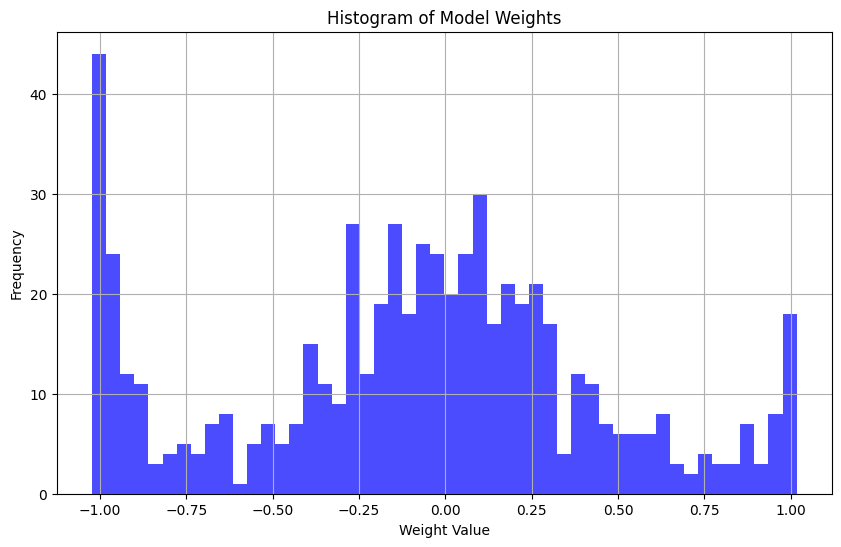

In [75]:
# temp_model = SimpleCNN(num_classes).to(device)
temp_model = SimpleMLP(input_size, num_classes).to(device)
def plot_model_weights_histogram(model):
    # Collect all weights in the model
    all_weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:  # only take weights, ignore biases
            all_weights.extend(param.data.cpu().numpy().flatten())
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(all_weights, bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Model Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_model_weights_histogram(model=model)

In [76]:
# torch.save(model.state_dict(), "data/cnn_with_leakyRelu.pth")



In [77]:

total_params = sum(p.numel() for p in temp_model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 7850


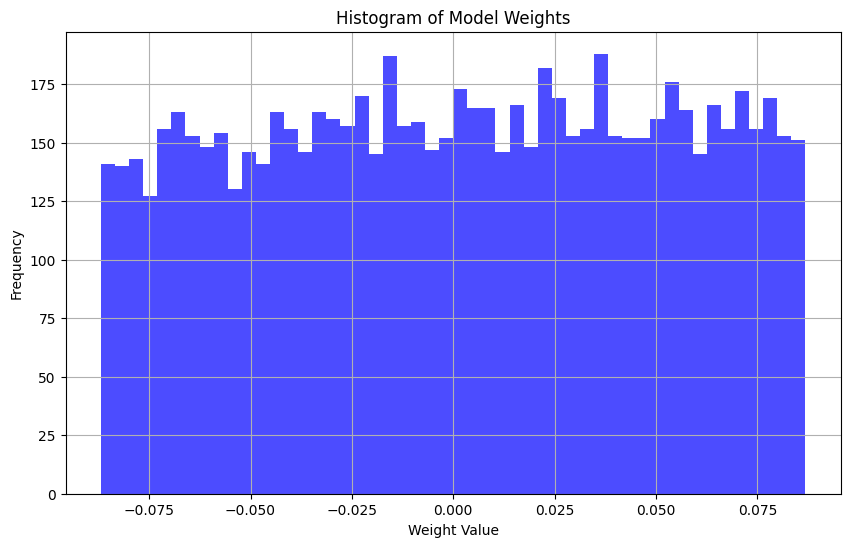

In [78]:


plot_model_weights_histogram(model=temp_model)